<a href="https://colab.research.google.com/github/ViktoryLoktionova/dl_nlp_yelp_polarity/blob/main/dl_nlp_yelp_polarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
num_words = 10000
max_review_len = 100

In [3]:
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz

--2021-11-12 11:37:59--  https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz [following]
--2021-11-12 11:38:00--  https://www.dropbox.com/s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2532378fd446da3151100f4b1a.dl.dropboxusercontent.com/cd/0/get/BZ0vEuspuqt_F7fWMfhW3c5vkGyHV7Ut0asyAxkP3VI9E97SrjDcWqrR5NBDGZfLPPyVkplcI0Gm4O3yi7I0WmfAVtqK8E_fI036v9DMQ3s8vKDVa-KI-gNjE2lTzivKvUsL5iH1udufC57u-jjlmU1e/file?dl=1# [following]
--2021-11-12 11:38:00--  https://uc2532378fd446da3151100f4b1a.dl.dropboxusercontent.com/cd/0/get/BZ0vEuspuqt_F7fWMfhW3c5vkGyHV7Ut0asyA

In [4]:
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


In [5]:
!cat yelp_review_polarity_csv/readme.txt

Yelp Review Polarity Dataset

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the

In [6]:
!head yelp_review_polarity_csv/train.csv

"1","Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
"2","Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. H

In [7]:
!head yelp_review_polarity_csv/test.csv

"2","Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
"1","Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \""fixed\"" it for free, and the very next morning I had the same issue. I called to complain, and the \""manager\"" didn't even apolog

In [8]:
!wc -l yelp_review_polarity_csv/train.csv
!wc -l yelp_review_polarity_csv/test.csv

560000 yelp_review_polarity_csv/train.csv
38000 yelp_review_polarity_csv/test.csv


In [9]:
train = pd.read_csv('yelp_review_polarity_csv/train.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [10]:
train

,Class,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


Выделяем данные для обучения

In [11]:
reviews = train['Review']

In [12]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

In [13]:
y_train = train['Class'] - 1

In [20]:
y_train

0         0
1         1
2         0
3         0
4         1
         ..
559995    1
559996    1
559997    0
559998    0
559999    1
Name: Class, Length: 560000, dtype: int64

токенизация текста

In [21]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

In [22]:
tokenizer = Tokenizer(num_words=num_words)

In [25]:
tokenizer.fit_on_texts(reviews)

In [ ]:
tokenizer.word_index

In [27]:
sequences = tokenizer.texts_to_sequences(reviews)

In [28]:
index = 0
print(reviews[index])
print(sequences[index])

Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
[707, 1, 4339, 7, 173, 939, 1665, 11, 5, 2161, 7, 1, 137, 112, 24, 18, 27, 189, 80, 3128, 10, 2636, 34, 1416, 462, 129, 8, 519, 13, 177, 129, 803, 88, 3812, 1, 446, 8, 392, 841, 115, 360, 7, 4136, 1438, 4, 43, 59, 1266, 118, 95, 46, 9, 13, 49, 1687, 4, 418, 18, 8, 3, 23, 563, 178, 16, 460, 18, 189, 80, 3128, 2, 3, 40, 78, 43, 8, 20, 23, 644, 1343, 20, 23

In [29]:
tokenizer.word_index['frustration']

4339

In [30]:
x_train = pad_sequences(sequences, maxlen= max_review_len)

In [ ]:
x_train[:5]

In [32]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [34]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor = 'val_accuracy',
                                      save_best_only = True,
                                      verbose = 1)

In [35]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=5,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

Epoch 1/5
3938/3938 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9164
Epoch 00001: val_accuracy improved from -inf to 0.95087, saving model to best_model.h5
3938/3938 [==============================] - 117s 28ms/step - loss: 0.2090 - accuracy: 0.9164 - val_loss: 0.1301 - val_accuracy: 0.9509
Epoch 2/5
3937/3938 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9441
Epoch 00002: val_accuracy improved from 0.95087 to 0.95654, saving model to best_model.h5
3938/3938 [==============================] - 109s 28ms/step - loss: 0.1448 - accuracy: 0.9441 - val_loss: 0.1123 - val_accuracy: 0.9565
Epoch 3/5
3937/3938 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9534
Epoch 00003: val_accuracy improved from 0.95654 to 0.95768, saving model to best_model.h5
3938/3938 [==============================] - 108s 27ms/step - loss: 0.1224 - accuracy: 0.9534 - val_loss: 0.1147 - val_accuracy: 0.9577
Epoch 4/5
3936/3938 [=============

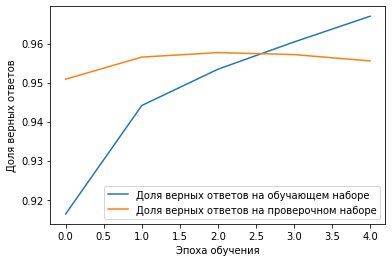

In [36]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

In [37]:
model.load_weights(model_save_path)

In [38]:
test = pd.read_csv('yelp_review_polarity_csv/test.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
test

In [40]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [43]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

In [41]:
y_test = test['Class'] - 1

In [44]:
model.evaluate(x_test, y_test, verbose=1)

1188/1188 [==============================] - 12s 10ms/step - loss: 0.1437 - accuracy: 0.9456


[0.14367452263832092, 0.9456315636634827]

Оцениваем тональность на собственном отзыве

In [45]:
text = '''
this is a great restaurant! the food is delicious, the waiters are polite. the location is convenient. the interior is beautiful!
'''

In [46]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
sequence

In [48]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [49]:
result = model.predict(data)


In [50]:
result

array([[0.9960181]], dtype=float32)

In [51]:
if result[[0]] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

Отзыв положительный
